In [ ]:

import pandas as pd 
import string

#Stuff for ngrams and preprocessing
from nltk.util import pad_sequence
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten
from nltk import word_tokenize, sent_tokenize 
from nltk.corpus import stopwords

#Stuff for machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier

#For results
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 

#For a snazzier confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Importing the dataset and having a look
df = pd.read_csv (r'/Users/williamfry/AmazonSentiment/preprocessed_kindle_review .csv')
df = df.drop(df.columns[0], axis=1)

df.head()

In [ ]:
df.shape


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
ratings = list(df['rating'])
sns.histplot(ratings, kde=False, discrete=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings')
plt.show()

In [79]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
def clean_text(df, index):
    df = df.dropna()
    df.iloc[:, index] = df.iloc[:, index].str.replace('\d+', '', regex=True) # Removing numbers
    df.iloc[:, index] = df.iloc[:, index].str.replace('[^\w\s]', '', regex=True) # Removing punctuation
    df.iloc[:, index] = df.iloc[:, index].str.lower() # Lowering all text
    return df

def remove_stopwords(df, index):
    stop = stopwords.words('english')
    stop.extend(('book', 'story', 'read', 'author','books'))
    df.iloc[:, index] = df.iloc[:, index].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    return df
df = clean_text(df, 1)
df = remove_stopwords(df, 1)
df = clean_text(df, 2)
df = remove_stopwords(df, 2)
df.head(10)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/williamfry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,rating,reviewText,summary
0,5,first bookmobile bought school club loved bet ...,years ago
1,1,description couldnt wait downloaded kindle fou...,boring boring boring
2,5,edit review believe got right updated rewrite ...,wigglelisciousnew toy ready
3,5,dont normally buy mystery novels dont like how...,good
4,5,isnt kind normally although try limit certain ...,great
5,4,really enjoyed developed wellwritten scifi dep...,alien scientist gets lost oregon wilderness hu...
6,3,bought loved cover try civil war romance come ...,hot civil war wanted romance
7,5,thoroughly enjoyed beginning end line full det...,wow wonderful twist
8,4,first entry series toddlers first clumsy attem...,steadily getting better
9,1,bought set returned couldnt force finish first...,childish writing


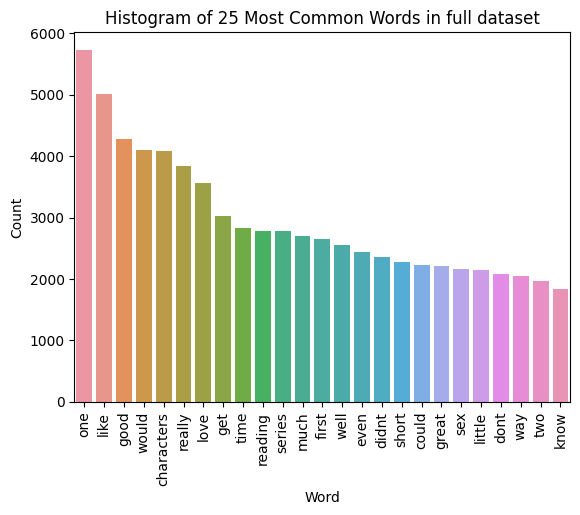

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
words = df['reviewText'].str.split()
words = words.explode()
word_counts = words.value_counts().reset_index()
word_counts.columns = ['Word', 'Count']
new_df = word_counts.copy()
new_df.head(10)
sns.barplot(data=new_df.head(25), x='Word', y='Count')
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Histogram of 25 Most Common Words in full dataset')
plt.show()


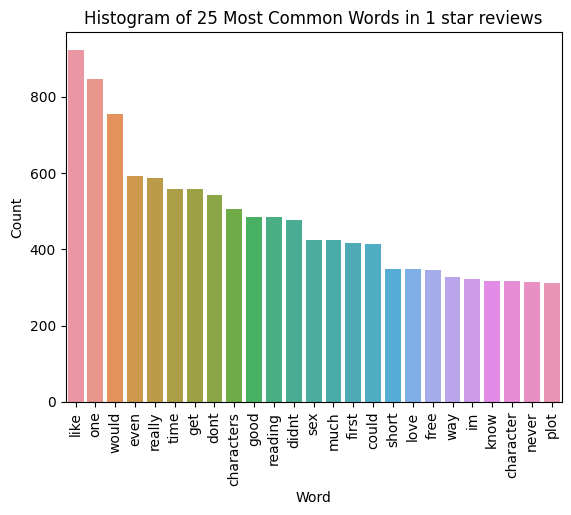

In [81]:
df_1star = df[df['rating'] == 1].copy()

import seaborn as sns
import matplotlib.pyplot as plt
words = df_1star['reviewText'].str.split()
words = words.explode()
word_counts = words.value_counts().reset_index()
word_counts.columns = ['Word', 'Count']
new_df = word_counts.copy()
new_df.head(10)
sns.barplot(data=new_df.head(25), x='Word', y='Count')
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Histogram of 25 Most Common Words in 1 star reviews')
plt.show()



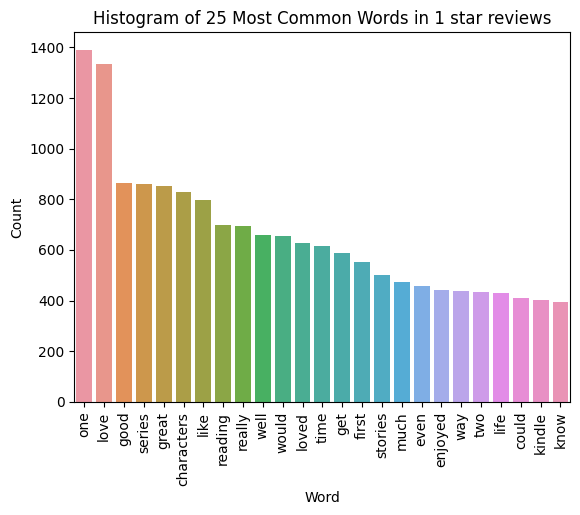

In [82]:
df_5star = df[df['rating'] == 5].copy()


import seaborn as sns
import matplotlib.pyplot as plt
words = df_5star['reviewText'].str.split()
words = words.explode()
word_counts = words.value_counts().reset_index()
word_counts.columns = ['Word', 'Count']
new_df = word_counts.copy()
new_df.head(10)
sns.barplot(data=new_df.head(25), x='Word', y='Count')
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Histogram of 25 Most Common Words in 1 star reviews')
plt.show()


In [ ]:
#Removing the parts of the dataset we don't actually need
df = df.drop(['summary', 'Unnamed: 0'], axis = 1)

#Removing puctuation from the text
df['cleanedText'] = df['reviewText'].apply(lambda x:remove_punctuation(x))


#Creating the X and y variables
y=df['rating'].values
X=df['cleanedText'].values

In [ ]:
#defining the function to remove punctuation
def remove_punctuation(text):
  if(type(text)==float):
    return text
  ans=""  
  for i in text:     
    if i not in string.punctuation:
      ans+=i    
  return ans

In [ ]:
#Removing puctuation from the text
df['cleanedText'] = df['reviewText'].apply(lambda x:remove_punctuation(x))


#Creating the X and y variables
y=df['rating'].values
X=df['cleanedText'].values

In [ ]:
#Text vectorisation
vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,1))

X_tidf = vectorizer.fit_transform(X)
(X_train,X_test,y_train,y_test)=train_test_split(X_tidf,y, random_state=0)

In [ ]:
#Function to train the neural network on the data returns the predicted and actual test y data
def neuralNetworkSimple(X, y, layers, solver):
    (X_train,X_test,y_train,y_test)=train_test_split(X,y, random_state=0)
    classifier = MLPClassifier(hidden_layer_sizes=layers, random_state=0,solver= solver)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    return y_test,y_pred

#Function to create a fancier confusion matrix using seaborn
def confusionMatrix(y_test,y_pred, lables):
    matrix =  confusion_matrix(y_test, y_pred)
    ax= plt.subplot()
    heat = sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap='Reds')
    ax.xaxis.set_ticklabels(lables)
    ax.yaxis.set_ticklabels(lables)
    return heat

In [ ]:
#Running the functions for the neural network
y_test,y_pred = neuralNetworkSimple(X_tidf, y, (32, 16, 8), 'lbfgs')
#Creating the axis lables for confusion matrix
lables = list(range(1,6))
#Making the confusion matrix
confusionMatrix(y_test, y_pred, lables)